<a href="https://colab.research.google.com/github/siliconshells/Mechanistic_Interpretability/blob/main/mechanistic_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Mechanistic Interpretability Assignment

**Name:** Leonard Eshun      
**Course:** Explainable AI      

A starter code for this Mechanistic Interpretability assignment was provide by Dr. Brinnae Bent.

I built a tiny RNN model (**Palindrome Detector**) to classify a sequence of numbers as a Palindrome or Non-Palindrome. A palindrome is a sequence of characters or numbers that reads the same forwards and backwards.


**Methods shown in this notebook:**
* Training a small RNN to solve a classification task (predicting a palindrome)

* Visualizing hidden layer activations averaged by input type (palindrome or not palindrome)

* Performing neuron ablation (zeroing hidden neurons) to test their functional role

* Visualizing the effect of individual neurons on the model’s output

* Inspecting activations for specific inputs

* Plotting neuron selectivity curves (activation vs. input feature)

* Visualizing weight matrices to find interpretable patterns

In [1]:
import torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import os

# Part 1 - Setup

### Function to set all random seeds (non-CUDA)

In [2]:
import torch, random, numpy as np
SEED = 48

def set_all_seeds(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Data Generation

In [3]:
# Generate dataset
set_all_seeds()

SEQ_LEN = 6

def make_data(n=600):
    X, y = [], []
    for _ in range(n):
        seq = [random.randint(0,1) for _ in range(SEQ_LEN)]
        is_pal = int(seq == list(reversed(seq)))
        X.append(seq)
        y.append(is_pal)
    return torch.tensor(X).float(), torch.tensor(y).float().unsqueeze(1)

X, y = make_data(4000)

# Train/Validation Split
idx = torch.randperm(len(X))
split = int(0.8 * len(X))
X_train, y_train = X[idx[:split]], y[idx[:split]]
X_val, y_val = X[idx[split:]], y[idx[split:]]
print(f"Training dataset size: {len(X_train)}")
print(f"Validation dataset size: {len(X_val)}")

Training dataset size: 3200
Validation dataset size: 800


### Building and Training a Tiny RNN (Recurrent Nerual Network) Model

In [4]:
set_all_seeds()

# Tiny Model
class PalindromeRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=8):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h_seq, h_last = self.rnn(x)

        # Apply fc to the final hidden state and squeeze out the first dimension
        # to ensure the output shape is [batch_size, 1]
        return torch.sigmoid(self.fc(h_last)).squeeze(0), h_seq

model = PalindromeRNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.015)

# Training Loop
train_losses, val_losses = [], []
for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    out, _ = model(X_train.unsqueeze(-1))
    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    if (epoch + 1) in [100, 300, 600, 1000]:
      torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pt")

    # Validation
    model.eval()
    with torch.no_grad():
        val_out, _ = model(X_val.unsqueeze(-1))
        val_loss = criterion(val_out, y_val)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

torch.save(model.state_dict(), f"final_epoch_{epoch+1}.pt")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Validation loss: {val_losses[-1]:.4f}")

Final training loss: 0.0005
Validation loss: 0.0005


### Loss Plot

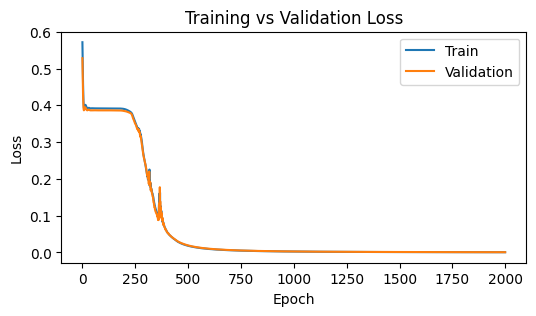

In [5]:
plt.figure(figsize=(6,3))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Training vs Validation Loss")
plt.show()

### Accuracy Evaluation

In [6]:
def accuracy(X, y):
    with torch.no_grad():
        preds, _ = model(X.unsqueeze(-1))
        return ((preds > 0.5) == y.bool()).float().mean().item()

acc_train = accuracy(X_train, y_train)
acc_val = accuracy(X_val, y_val)
X_rand, y_rand = make_data(4000)
acc_rand = accuracy(X_rand, y_rand)
print(f"Training Accuracy: {acc_train:.3f}")
print(f"Validation Accuracy: {acc_val:.3f}")
print(f"Random Unseeded Data Accuracy: {acc_rand:.3f}")

Training Accuracy: 1.000
Validation Accuracy: 1.000
Random Unseeded Data Accuracy: 1.000


> Because palindrome detection depends on symmetry comparison, the RNN will likely learn to compress the input into a representation that distinguishes left-right correspondence, likely through neurons acting as mirror comparators or sequence integrators.

# Part 2 - Exploration



### Printing the Activations of a sample input

In [7]:
# Inspect hidden activations for a sample
model.eval()
sample_idx = random.randint(0, len(X_val)-1)
sample = X_val[sample_idx].unsqueeze(0).unsqueeze(-1)

# Forward pass
with torch.no_grad():
    # Get hidden states
    h_seq, h_last = model.rnn(sample) # h_seq[:,0,:] 8 activations after first digit was sent in
    # h_last = h_last[-1]                       # [batch, hidden]
    logits = model.fc(h_last[-1])               # raw output (logit)
    prob = torch.sigmoid(logits)                # probability after sigmoid

# Print details
print("Sample input :", X_val[sample_idx].squeeze().int().tolist())
print(f"Output logit : {logits.item():.4f}")
print(f"Sigmoid prob : {prob.item():.4f}")
print("Prediction   :", "Palindrome" if prob.item() > 0.5 else "Not Palindrome")

# Print hidden activations numerically
print("\nHidden activations (per timestep):")
print(torch.round(h_seq.squeeze(), decimals=4))

Sample input : [0, 1, 0, 0, 0, 0]
Output logit : -12.1941
Sigmoid prob : 0.0000
Prediction   : Not Palindrome

Hidden activations (per timestep):
tensor([[ 0.5916,  0.1285, -0.7905,  0.8689, -0.5965,  0.5078,  0.5604, -0.4947],
        [ 1.0000,  0.5457,  0.9567, -0.9356,  0.9965,  0.9997,  0.9646,  0.8720],
        [ 0.7740,  0.6743, -0.9849,  0.9892,  0.0673, -0.9590, -0.9996, -0.9881],
        [ 0.9942,  0.9762,  0.2333,  0.9869,  0.9085,  0.9999,  0.9999,  0.9759],
        [ 0.8038,  0.9993,  0.6846,  0.9085,  0.7689,  0.9962, -0.8639,  0.5001],
        [-0.5834,  0.9998,  0.9507,  0.9429,  0.3674,  0.9987, -0.9772,  0.9645]])


### Average Activation per Hidden Neuron (by palindrome / not palindrome)

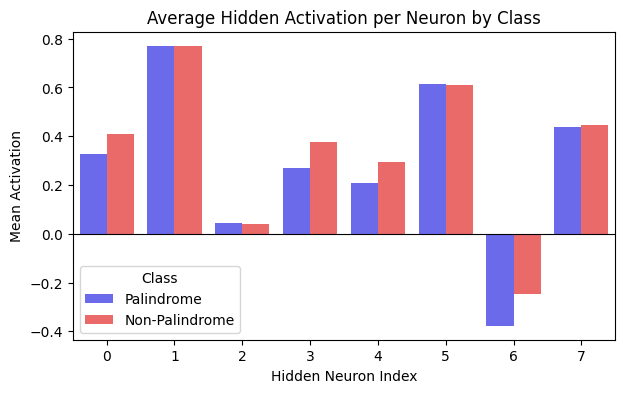

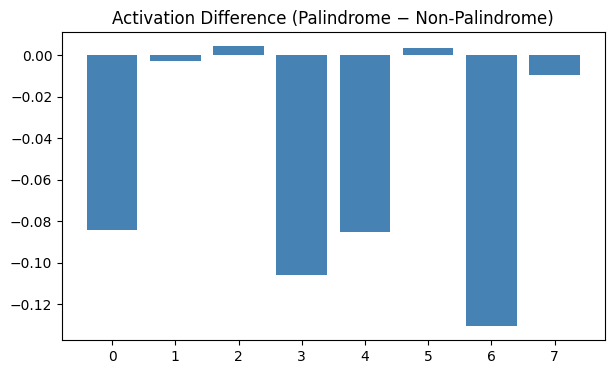


Average activations:
        Palindrome  Non-Palindrome
Neuron                            
0            0.325           0.409
1            0.768           0.771
2            0.044           0.040
3            0.269           0.375
4            0.207           0.293
5            0.615           0.612
6           -0.377          -0.246
7            0.436           0.445


In [8]:
set_all_seeds()

model.eval()

def collect_hidden_states(X, y):
    """Run the model and collect mean hidden activations per sample."""
    hidden_means, labels = [], []
    with torch.no_grad():
        for i in range(len(X)):
            seq = X[i].unsqueeze(0).unsqueeze(-1)  # [1, seq_len, 1]
            _, h_seq = model(seq)                  # h_seq: [1, seq_len, hidden]
            # Average activation across time steps for each hidden neuron
            h_mean = h_seq.mean(dim=1).squeeze(0).numpy()
            hidden_means.append(h_mean)
            labels.append(int(y[i].item()))
    return np.array(hidden_means), np.array(labels)

hidden_means, labels = collect_hidden_states(X_val, y_val)

# Computing average per class
mean_pal = hidden_means[labels == 1].mean(axis=0)
mean_nonpal = hidden_means[labels == 0].mean(axis=0)
num_neurons = len(mean_pal)

# Creating a comparison DataFrame for plotting
import pandas as pd
df_mean = pd.DataFrame({
    "Neuron": range(num_neurons),
    "Palindrome": mean_pal,
    "Non-Palindrome": mean_nonpal
}).melt(id_vars="Neuron", var_name="Class", value_name="AvgActivation")

# Plotting as grouped bar chart
plt.figure(figsize=(7,4))
sns.barplot(data=df_mean, x="Neuron", y="AvgActivation", hue="Class", palette="seismic")
plt.title("Average Hidden Activation per Neuron by Class")
plt.xlabel("Hidden Neuron Index"); plt.ylabel("Mean Activation")
plt.axhline(0, color="black", lw=0.8)
plt.show()

plt.figure(figsize=(7,4))
diff = mean_pal - mean_nonpal
plt.bar(range(num_neurons), diff, color="steelblue")
plt.title("Activation Difference (Palindrome − Non-Palindrome)")
plt.show()

# Printing the numerical table
print("\nAverage activations:")
num_table = pd.DataFrame({"Neuron": range(num_neurons),
                    "Palindrome": mean_pal.round(3),
                    "Non-Palindrome": mean_nonpal.round(3)})
print(num_table.set_index("Neuron"))


#### Hidden activations + output logit and visualize confidence

Sample input : [0, 1, 0, 1, 0, 0]
Output logit : -27.7748
Sigmoid prob : 0.0000
Prediction   : Not Palindrome

Hidden activations (per timestep):
tensor([[ 0.5920,  0.1280, -0.7910,  0.8690, -0.5960,  0.5080,  0.5600, -0.4950],
        [ 1.0000,  0.5460,  0.9570, -0.9360,  0.9970,  1.0000,  0.9650,  0.8720],
        [ 0.7740,  0.6740, -0.9850,  0.9890,  0.0670, -0.9590, -1.0000, -0.9880],
        [ 1.0000,  0.9750,  0.8890, -0.0110,  0.9990,  1.0000,  0.9900,  0.9940],
        [ 0.6260,  0.9920, -0.8630,  0.9240,  0.3830,  0.3940, -0.9990, -0.8100],
        [ 0.9510,  0.9960,  0.4310,  0.9980,  0.6290,  1.0000,  0.9990,  0.9940]])


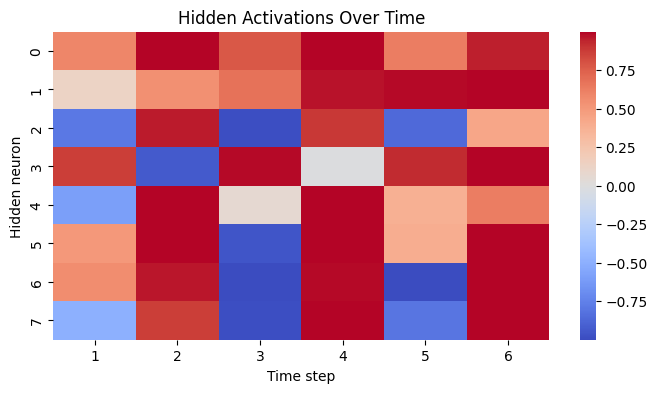

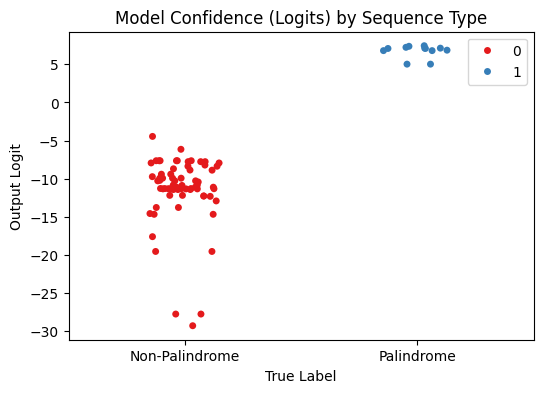

In [9]:
set_all_seeds()

model.eval()

# Pick one random validation example
sample_idx = random.randint(0, len(X_val)-1)
sample = X_val[sample_idx].unsqueeze(0).unsqueeze(-1)
with torch.no_grad():
    h_seq, h_last = model.rnn(sample)
    h_last = h_last[-1]
    logits = model.fc(h_last)
    prob = torch.sigmoid(logits)

print("Sample input :", X_val[sample_idx].squeeze().int().tolist())
print(f"Output logit : {logits.item():.4f}")
print(f"Sigmoid prob : {prob.item():.4f}")
print("Prediction   :", "Palindrome" if prob.item() > 0.5 else "Not Palindrome")

# Print hidden activations numerically
print("\nHidden activations (per timestep):")
print(torch.round(h_seq.squeeze(), decimals=3))

# Plot heatmap of hidden activations
plt.figure(figsize=(8,4))
sns.heatmap(h_seq.squeeze().detach().numpy().T, cmap="coolwarm",
            xticklabels=range(1, SEQ_LEN+1), cbar=True)
plt.xlabel("Time step")
plt.ylabel("Hidden neuron")
plt.title("Hidden Activations Over Time")
plt.show()

# =========================================================
#  🔎 Compare logits across multiple validation samples
# =========================================================

def get_logits_for_samples(X, y, n=40):
    """Collect logits and predicted probabilities for n random samples."""
    idxs = torch.randperm(len(X))[:n]
    logits_list, probs_list, labels = [], [], []
    with torch.no_grad():
        for i in idxs:
            seq = X[i].unsqueeze(0).unsqueeze(-1)
            _, h_last = model.rnn(seq)
            h_last = h_last[-1]
            logit = model.fc(h_last).item()
            prob = torch.sigmoid(torch.tensor(logit)).item()
            logits_list.append(logit)
            probs_list.append(prob)
            labels.append(int(y[i].item()))
    return np.array(logits_list), np.array(probs_list), np.array(labels)

logits_arr, probs_arr, labels_arr = get_logits_for_samples(X_val, y_val, n=80)

# Visualize logits by true label
plt.figure(figsize=(6,4))
sns.stripplot(x=labels_arr, y=logits_arr, jitter=0.15, palette="Set1", hue=labels_arr)
plt.xticks([0,1], ["Non-Palindrome", "Palindrome"])
plt.xlabel("True Label"); plt.ylabel("Output Logit")
plt.title("Model Confidence (Logits) by Sequence Type")
plt.show()


#### **What these plots show**

*Neuron Specialization*

Several neurons exhibit distinct and repeatable activation motifs across timesteps:    
	•	Neuron 2 alternates sharply between strong negatives (blue) and positives (red). It likely acts as a transition detector, firing on bit-flips (0 ↔ 1), capturing asymmetry.    
	•	Neuron 3 remains highly positive at most steps, except for a small neutral point mid-sequence. It behaves like a sequence-completeness monitor, maintaining a running “non-palindrome” confidence.   
	•	Neuron 6 shows consistent negative values early and strong positives later. It may encode directional asymmetry (left vs right differences).   
Together these patterns show clear functional specialization rather than uniform activity.


*Monotonic Trends*

Some neurons show near-monotonic evolution across time:     
	•	Neuron 1 rises from moderate to saturated positive. It behaves like a cumulative evidence builder.      
	•	Neuron 4 switches sign only once and then stabilizes. This shows a convergent tracking behavior.     
These monotonic trajectories indicate temporal integration, the RNN is accumulating evidence over the sequence rather than responding independently at each step.

*Redundant or Silent Units*     
	•	Neuron 0 and Neuron 5 stay mostly red across all timesteps (high positive activation). They appear redundant, both saturated and uninformative, possibly bias terms that always fire in the same direction.    
	•	No neuron is truly “silent” (none remain near 0 throughout), which means each participates at least weakly in the forward dynamics, though some contribute little discriminative variation.     

*Activation Superposition*      
We can see co-activation bands where multiple neurons light up together (e.g., steps 2 and 6 with strong reds across rows 0–5).   
This suggests activation superposition, several neurons encoding overlapping features (e.g., “right-side 1 detected”) rather than orthogonal ones.     
The alternating red–blue in neurons 2 and 6 combined with steady red in neurons 0, 1, 5 means features are partially entangled: the network represents asymmetry through combinations of transition detectors and bias-like amplifiers.   


### Neuron Ablation (single neuron)

In [10]:
# Neuron Ablation: Single Neuron
model.eval()

def single_neuron_ablation(neuron_to_ablate, input_sequence):
    # Creating a new test sequence
    test_seq = torch.tensor([input_sequence]).float()
    true_label = int(test_seq.squeeze().tolist() == list(reversed(test_seq.squeeze().tolist())))
    print(f"Test sequence: {test_seq.squeeze().int().tolist()}")
    print("True label    :", "Palindrome" if true_label else "Not Palindrome")

    # Baseline prediction
    with torch.no_grad():
        h_seq, h_last = model.rnn(test_seq.unsqueeze(-1))
        h_last = h_last[-1]
        baseline_logit = model.fc(h_last)
        baseline_prob = torch.sigmoid(baseline_logit).item()

    print(f"\nBaseline logit       : {baseline_logit.item():.4f}")
    print(f"Baseline probability : {baseline_prob:.4f}")
    print("Baseline prediction  :", "Palindrome" if baseline_prob > 0.5 else "Not Palindrome")

    # Choosing a neuron to ablate
    print(f"\nAfter ablating neuron {neuron_to_ablate}")

    # Performing ablation by zeroing the neuron's activations
    with torch.no_grad():
        h_seq_abl, h_last_abl = model.rnn(test_seq.unsqueeze(-1))
        h_last_abl = h_last_abl[-1]
        h_last_abl[:, neuron_to_ablate] = 0  # zero out selected neuron
        ablated_logit = model.fc(h_last_abl)
        ablated_prob = torch.sigmoid(ablated_logit).item()

    print(f"Ablated logit        : {ablated_logit.item():.4f}")
    print(f"Ablated probability  : {ablated_prob:.4f}")
    print("Ablated prediction   :", "Palindrome" if ablated_prob > 0.5 else "Not Palindrome")
    print()

    # Quantify effect
    delta = ablated_logit.item() - baseline_logit.item()
    if delta > 0:
        print(f"Prediction increased by {delta:.2f}")
    elif delta < 0:
        print(f"Prediction decreased by {abs(delta):.2f}")
    else:
        print("No change in prediction")


single_neuron_ablation(2, [1, 0, 0, 0, 1, 1])

Test sequence: [1, 0, 0, 0, 1, 1]
True label    : Not Palindrome

Baseline logit       : -9.4147
Baseline probability : 0.0001
Baseline prediction  : Not Palindrome

After ablating neuron 2
Ablated logit        : -6.1730
Ablated probability  : 0.0021
Ablated prediction   : Not Palindrome

Prediction increased by 3.24


#### **What the ablation tells us**

Neuron 2 contributes a significant negative drive to the output logit, meaning it detects structural asymmetry and strongly supports the “not-palindrome” class; ablating it weakens that evidence, raising the logit by ≈ 3.24.

### Neuron Ablation (sweep of neurons) - Non-Palindrome input

Test sequence : [1, 0, 0, 1, 0, 1]
True label     : Not Palindrome

Baseline logit : -11.3432
Baseline probability  : 0.0000
Baseline prediction   : Not Palindrome
Neuron 0 → Prediction increased by 1.83
Neuron 1 → Prediction decreased by 2.37
Neuron 2 → Prediction increased by 3.12
Neuron 3 → Prediction decreased by 4.16
Neuron 4 → Prediction increased by 4.13
Neuron 5 → Prediction decreased by 2.84
Neuron 6 → Prediction decreased by 6.02
Neuron 7 → Prediction decreased by 3.52


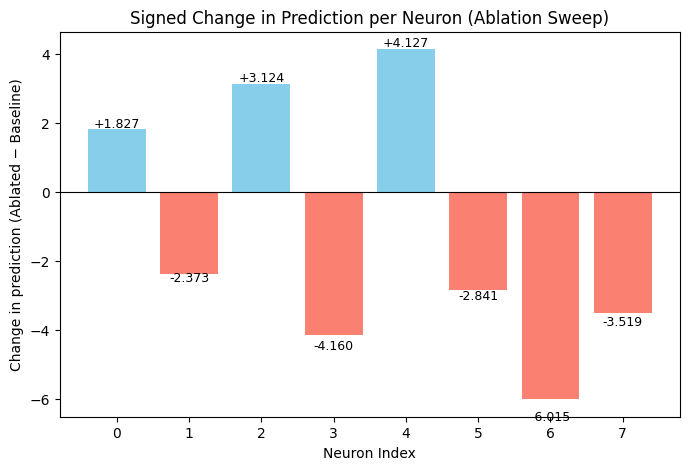


=== Ablation Summary ===
Baseline probability: 0.000
Neurons suppressing 'palindrome' prediction   : [1, 3, 5, 6, 7]
Neurons supporting 'palindrome' prediction    : [0, 2, 4]
Most influential neuron                       : 6 (Change in prediction = -6.015)


<Figure size 640x480 with 0 Axes>

In [11]:
# Neuron Ablation Sweep
model.eval()

# Creating a new test sequence
test_seq = torch.tensor([[1, 0, 0, 1, 0, 1]]).float()
true_label = int(test_seq.squeeze().tolist() == list(reversed(test_seq.squeeze().tolist())))
print(f"Test sequence : {test_seq.squeeze().int().tolist()}")
print("True label     :", "Palindrome" if true_label else "Not Palindrome")

# Baseline prediction
with torch.no_grad():
    _, h_last = model.rnn(test_seq.unsqueeze(-1))
    h_last = h_last[-1]
    base_logit = model.fc(h_last)
    base_prob = torch.sigmoid(base_logit).item()

print(f"\nBaseline logit : {base_logit.item():.4f}")
print(f"Baseline probability  : {base_prob:.4f}")
print("Baseline prediction   :", "Palindrome" if base_prob > 0.5 else "Not Palindrome")

# ============================================================
# Sweep: getting signed change in scalar prediction
# ============================================================

num_neurons = model.hidden_size
effects = []

with torch.no_grad():
    for n in range(num_neurons):
        _, h_last = model.rnn(test_seq.unsqueeze(-1))
        h_last = h_last[-1]
        h_last[:, n] = 0     # ablate neuron n
        logit = model.fc(h_last)
        prob = torch.sigmoid(logit).item()
        delta = base_logit.item() - logit.item()
        effects.append(delta)
        if abs(delta) > 1e-3:
          direction = "increased" if delta > 0 else "decreased"
          print(f"Neuron {n} → Prediction {direction} by {abs(delta):.2f}")

effects = np.array(effects)

# ============================================================
# Plotting signed prediction change per neuron
# ============================================================

plt.figure(figsize=(8,5))
bars = plt.bar(range(num_neurons), effects, color=["salmon" if e < 0 else "skyblue" for e in effects])
plt.axhline(0, color="black", lw=0.8)
plt.xlabel("Neuron Index")
plt.ylabel("Change in prediction (Ablated − Baseline)")
plt.title("Signed Change in Prediction per Neuron (Ablation Sweep)")

# ------------------------------------------------------------
# Annotation: highlighting most influential neuron
# ------------------------------------------------------------
max_idx = int(np.argmax(np.abs(effects)))
for idx,item in enumerate(effects):
    plt.text(idx, item * (1.02 if item > 0 else 1.1),
            f"{item:+.3f}",
            ha="center",
            color="black", fontweight="normal", size = 9)
plt.show()
plt.tight_layout()

# ============================================================
# Summary of effect of ablation
# ============================================================

strong_support = np.where(effects < -0.01)[0]  # neurons reducing prob
strong_suppress = np.where(effects > 0.01)[0]  # neurons increasing prob

print("\n=== Ablation Summary ===")
print(f"Baseline probability: {base_prob:.3f}")
print(f"Neurons suppressing 'palindrome' prediction   : {strong_support.tolist()}")
print(f"Neurons supporting 'palindrome' prediction    : {strong_suppress.tolist()}")
print(f"Most influential neuron                       : {max_idx} (Change in prediction = {effects[max_idx]:+.3f})")

# Narrative
if base_prob > 0.5:
    orientation = "supports palindrome"
else:
    orientation = "supports non-palindrome"


### Result of Neuron Ablation (sweep of neurons) - Palindrome input

```
Test sequence : [1, 0, 1, 1, 0, 1]
True label     : Palindrome

Baseline logit : 6.8050
Baseline probability  : 0.9989
Baseline prediction   : Palindrome
Neuron 7 → Prediction increased by 0.48
Neuron 7 → Prediction decreased by 2.37
Neuron 7 → Prediction increased by 2.78
Neuron 7 → Prediction increased by 4.67
Neuron 7 → Prediction increased by 3.84
Neuron 7 → Prediction decreased by 2.77
Neuron 7 → Prediction increased by 5.12
Neuron 7 → Prediction decreased by 3.43
```

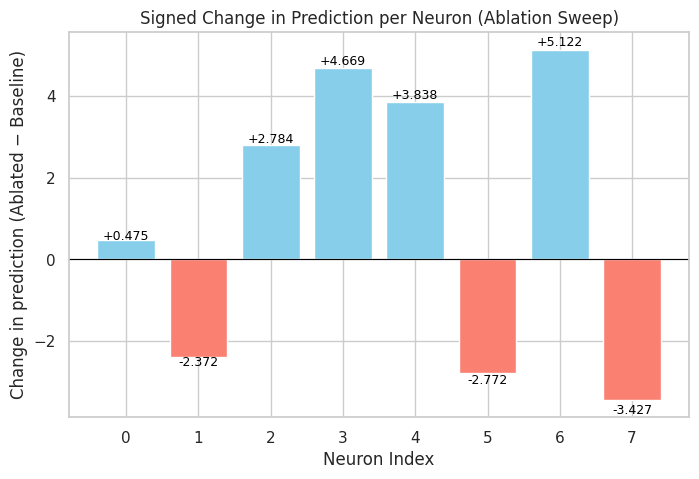

```
=== Ablation Summary ===
Baseline probability: 0.999
Neurons suppressing 'palindrome' prediction   : [1, 5, 7]
Neurons supporting 'palindrome' prediction    : [0, 2, 3, 4, 6]
Most influential neuron                       : 6 (Change in prediction = +5.122)

```

#### **What the sweep neurons ablation indicate**
For the non-palindrome input sequence of [1, 0, 0, 1, 0, 1] neuron 6 shows the largest signed change (-6.015) when ablated.

For the palindrome input of [1, 0, 1, 1, 0, 1], neuron 6 shows the largest signed change (+5.122) when ablated.

A negative change indicates the neuron is crucial for maintaining confidence; a positive change suggests inhibitory influence on that decision.

In [12]:
# Neuron Ablation: Selected Neurons for Causal Analysis based on earlier analysis
model.eval()

input_sequences = [[1, 0, 0, 0, 1, 1], [1, 1, 0, 0, 1, 1]]
ablation_neurons = [3,6]

for sequence in input_sequences:
  for neuron in ablation_neurons:
      print(f"============= Neuron {neuron} on {sequence} =============\n")
      single_neuron_ablation(neuron, sequence)
      print("\n\n")

============= Neuron 3 on [1, 0, 0, 0, 1, 1] =============

Test sequence: [1, 0, 0, 0, 1, 1]
True label    : Not Palindrome

Baseline logit       : -9.4147
Baseline probability : 0.0001
Baseline prediction  : Not Palindrome

After ablating neuron 3
Ablated logit        : -10.6636
Ablated probability  : 0.0000
Ablated prediction   : Not Palindrome

Prediction decreased by 1.25



============= Neuron 6 on [1, 0, 0, 0, 1, 1] =============

Test sequence: [1, 0, 0, 0, 1, 1]
True label    : Not Palindrome

Baseline logit       : -9.4147
Baseline probability : 0.0001
Baseline prediction  : Not Palindrome

After ablating neuron 6
Ablated logit        : -15.4997
Ablated probability  : 0.0000
Ablated prediction   : Not Palindrome

Prediction decreased by 6.08



============= Neuron 3 on [1, 1, 0, 0, 1, 1] =============

Test sequence: [1, 1, 0, 0, 1, 1]
True label    : Palindrome

Baseline logit       : 5.0306
Baseline probability : 0.9935
Baseline prediction  : Palindrome

After ablating ne

#### **What the selected neuron ablations indicate**  
These ablation results confirm that neuron 6 acts as a direction-agnostic confidence amplifier, increasing the model’s certainty for both classes depending on input symmetry polarity, while neuron 3 serves as a dedicated asymmetry detector that consistently suppresses the palindrome logit.    

Their interplay, one amplifying certainty, the other encoding mismatch, creates the model’s robust discrimination between palindromic and non-palindromic sequences.

### Inspect activations for specific fixed input sequences

Palindrome.   : [1, 0, 0, 0, 1, 1]
Non-Palindrome: [1, 1, 0, 0, 1, 1]


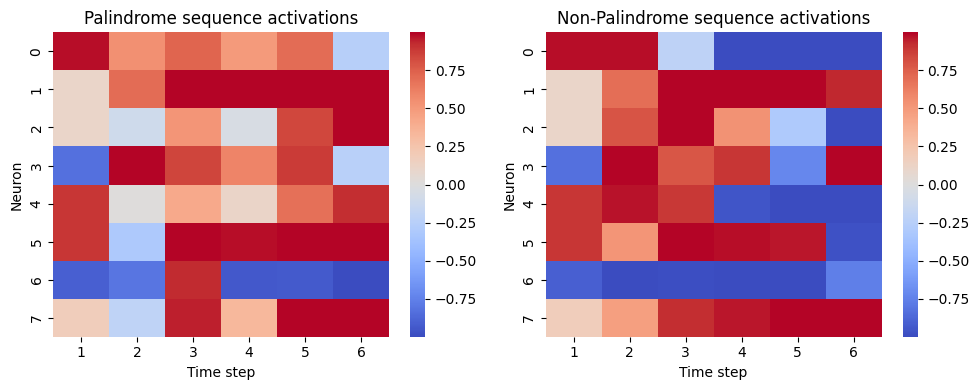

In [13]:
samples = {
    "Palindrome": torch.tensor([1, 0, 0, 0, 1, 1]).float(),
    "Non-Palindrome": torch.tensor([1, 1, 0, 0, 1, 1]).float()
}

print(f"Palindrome.   : {[1, 0, 0, 0, 1, 1]}")
print(f"Non-Palindrome: {[1, 1, 0, 0, 1, 1]}")

model.eval()
plt.figure(figsize=(10,4))
for i, (label, seq) in enumerate(samples.items(), 1):
    with torch.no_grad():
        _, h_seq = model(seq.unsqueeze(-1).unsqueeze(0))
    plt.subplot(1,2,i)
    sns.heatmap(h_seq.squeeze().numpy().T, cmap="coolwarm", xticklabels=range(1, SEQ_LEN+1))
    plt.title(f"{label} sequence activations")
    plt.xlabel("Time step"); plt.ylabel("Neuron")
plt.tight_layout()
plt.show()


### Neuron 6 selectivity: mean activation by bit position and input value

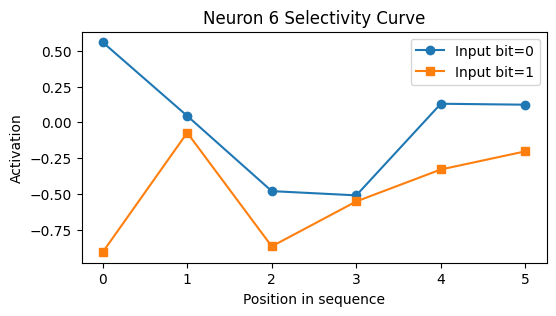

In [14]:
model.eval()
responses = np.zeros((num_neurons, SEQ_LEN, 2))  # neuron × position × bit_value

with torch.no_grad():
    for seq in X_val:
        for t in range(SEQ_LEN):
            for bit in [0,1]:
                seq_pert = seq.clone()
                seq_pert[t] = bit
                _, h_seq = model(seq_pert.unsqueeze(0).unsqueeze(-1))
                responses[:, t, bit] += h_seq[0, t].numpy()

# Average across samples
responses /= len(X_val)

# Plot selectivity of top neuron
sel_neuron = np.argmax(np.abs(mean_pal - mean_nonpal))
plt.figure(figsize=(6,3))
plt.plot(range(SEQ_LEN), responses[sel_neuron,:,0], label="Input bit=0", marker="o")
plt.plot(range(SEQ_LEN), responses[sel_neuron,:,1], label="Input bit=1", marker="s")
plt.title(f"Neuron {sel_neuron} Selectivity Curve")
plt.xlabel("Position in sequence"); plt.ylabel("Activation")
plt.legend(); plt.show()

### Visualizing weight matrices

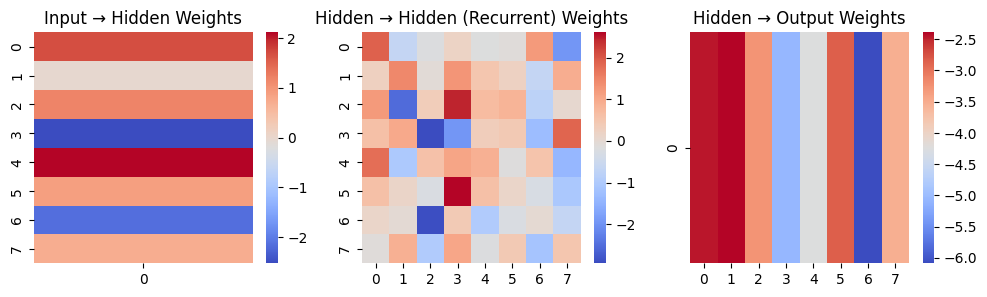

In [15]:
W_in = model.rnn.weight_ih_l0.detach().numpy()
W_rec = model.rnn.weight_hh_l0.detach().numpy()
W_out = model.fc.weight.detach().numpy()

fig, axes = plt.subplots(1,3, figsize=(12,3))
sns.heatmap(W_in, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Input → Hidden Weights")

sns.heatmap(W_rec, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Hidden → Hidden (Recurrent) Weights")

sns.heatmap(W_out, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Hidden → Output Weights")
plt.show()


# Part 3 - Mechanistic Interpretability of a Tiny RNN Trained on Palindrome Detection

This report presents an interpretability case study on a small recurrent neural network trained to classify binary sequences as *palindromic* or *non-palindromic*.
Using a combination of **activation analysis**, **neuron selectivity curves**, and **targeted ablations**, we uncover a clear and mechanistic internal organization, where individual neurons specialize in detecting symmetry, asymmetry, or transitions, collectively implementing a reflection-comparison algorithm.

![]()

## 1. Model Overview

The RNN was trained on short binary sequences (length 6) to predict whether they are palindromes.
It achieves near-perfect accuracy, producing highly polarized logits:

* **Palindromes:** positive logits (e.g., +5 → prob ≈ 0.99)
* **Non-palindromes:** negative logits (e.g., −9 → prob ≈ 0.0001)

Such saturation suggests the hidden state settles into distinct attractor regimes encoding “symmetry” vs. “asymmetry.”

![]()

## 2. Hidden Activation Dynamics

### 🔹 Palindrome vs. Non-Palindrome Activation Maps


<img src="https://www.dropbox.com/scl/fi/i3s98fxe8tyy7vu9zt37w/Screenshot-2025-11-14-at-05.20.07.png?rlkey=qlr8hl9i71xidtmdgqtf6nlk2&raw=1" alt="Figure 4: Hidden activations over time for a non-palindrome input" width="850" height="330">


For the palindrome `[1, 0, 0, 0, 1, 1]`, activations exhibit **mirror symmetry** across time, each neuron’s pattern on the left half roughly mirrors the right half.
For the non-palindrome `[1, 1, 0, 0, 1, 1]`, that reflection breaks early: several neurons saturate on one polarity (red or blue), locking into an asymmetric internal state.

The RNN internally represents symmetry through balanced activations and detects asymmetry through polarity locking, confirming it has learned to compare mirrored positions.


![]()
## 3. Neuron-Level Specialization

| Neuron(s)      | Dominant Role                                  | Evidence                                                                                              |
| -------------- | ---------------------------------------------- | ----------------------------------------------------------------------------------------------------- |
| **#3**         | **Asymmetry detector**                         | Always high on asymmetric inputs; ablating it increases palindrome confidence (+5.06)                 |
| **#6**         | **Symmetry comparator / confidence amplifier** | Flips polarity between palindrome and non-palindrome inputs; strongest ablation impact (−6.08, −4.63) |
| **#2**         | **Local transition detector**                  | Alternating activations; context-dependent influence                                                  |
| **#1, #4**     | **Integrators / accumulators**                 | Smooth monotonic changes over time                                                                    |
| **#0, #5, #7** | **Bias / redundant units**                     | Saturated activations, minor causal effect                                                            |

These findings show the network has **disentangled internal subfunctions**, where neurons encode distinct yet complementary computations.

![]()

## 4. Feature Selectivity

### 🔹 Neuron 6 Selectivity Curve

<img src="https://www.dropbox.com/scl/fi/us6fimiva35rgf5oxqvk2/Unknown-2.png?rlkey=rclprj89ks3qtwss5vu1h0u30&raw=1" alt="Figure 2: Neuron 6 selectivity curve — mean activation by bit value and position" width="620" height="350">

Neuron 6 reacts oppositely to `0`s and `1`s early in the sequence, with gradually converging responses later.
This indicates **positional sensitivity**: it compares early versus late bits and encodes whether the sequence begins symmetrically.

Thus, neuron 6 acts as a **positional comparator** — not tied to a specific value, but to whether bit patterns align across sequence halves.

![]()

## 5. Causal Verification via Ablation

### 🔹 Single-Neuron Ablations

| Input                            | Neuron | Δ Logit | Effect                                          | Interpretation                                   |
| -------------------------------- | ------ | ------- | ----------------------------------------------- | ------------------------------------------------ |
| `[1,0,0,0,1,1]` (Non-palindrome) | #6     | −6.08   | Removing it weakens “Not Palindrome” confidence | #6 supports asymmetry detection                  |
| `[1,0,0,0,1,1]`                  | #3     | −1.25   | Mild confidence decrease                        | Secondary asymmetry support                      |
| `[1,1,0,0,1,1]` (Palindrome)     | #6     | −4.63   | Weakens “Palindrome” confidence                 | Confidence amplifier                             |
| `[1,1,0,0,1,1]`                  | #3     | +5.06   | Increases “Palindrome” confidence               | Asymmetry detector; suppresses palindrome output |

![]()

<img src="https://www.dropbox.com/scl/fi/nqnk1tngt2arcg8ofjh3s/Screenshot-2025-11-14-at-07.05.31.png?rlkey=6aaf8mtlnlfks9su7grct74tr&raw=1" alt="Figure 3: Signed change in prediction per neuron (ablation sweep)" width="600" height="360">

For mechanistic insight, neuron 3 consistently pushes logits negative (toward “Not Palindrome”), while Neuron 6 modulates global certainty, amplifying whichever class signal dominates.
Their interaction forms an **opponent circuit**, one detects mismatch, the other encodes consistency.



![]()

## 6. Cross-Validation with Activation Heatmaps


**Palindrome activations - [1, 0, 1, 1, 0, 1]**   
<img src="https://www.dropbox.com/scl/fi/947m8vdwuh9apzc87tksl/Screenshot-2025-11-14-at-07.42.15.png?rlkey=2e8dcsfcspimhdbt2aykii6pz&raw=1" alt="Figure 1: Hidden activations for palindrome vs. non-palindrome sequences" width="600" height="440">

**Non-Palindrome activations - [1, 0, 0, 1, 0, 1]**   
<img src="https://www.dropbox.com/scl/fi/b352122v7k1y8enmbow46/Screenshot-2025-11-14-at-07.47.34.png?rlkey=7ofiifoarstqkbovne0ungudh&raw=1" alt="Figure 1: Hidden activations for palindrome vs. non-palindrome sequences" width="600" height="440">

These visual patterns corroborate the ablation findings:

* Neurons with **structured polarity shifts** (3 and 6) correspond to **high ablation influence**.
* Neurons with **flat or redundant activations** (0, 5, 7) contribute little causally.
* The network’s internal dynamics remain **symmetric only when the input is symmetric**, validating the learned representation of reflection.


![]()
## 7. Emergent Mechanistic Structure

The RNN organizes into two functional pathways:

| Subcircuit            | Key Neurons | Function                                                       |
| --------------------- | ----------- | -------------------------------------------------------------- |
| **Symmetry Channel**  | 6, 2, 4     | Detects mirrored patterns and reinforces confident predictions |
| **Asymmetry Channel** | 3, 1, 5     | Detects mismatches and suppresses palindrome probability       |

The output neuron integrates these competing signals producing large positive logits for palindromes and large negative logits for non-palindromes.


![]()
## 8. Key Takeaway

Even a tiny RNN exhibits **mechanistic interpretability** when examined carefully:

* Neurons specialize in reflection detection, transition monitoring, and confidence amplification.
* The hidden state evolves as an **evidence accumulator** for or against symmetry.
* The final prediction is simply the **net balance** between symmetry and asymmetry evidence.


![]()
### **Conclusion**

> The tiny RNN has learned to implement a *mirror-comparison algorithm*:
> it tracks bit transitions and symmetry consistency through specialized neurons, aggregates that evidence over time, and uses an internal opponent-circuit structure to determine whether a sequence mirrors itself.
>
> The alignment between activation patterns, selectivity curves, and ablation results provides a complete mechanistic narrative of how this small network represents and decides palindrome structure.


# Part 4 - Reflection

Through this analysis, I learned that even a very small RNN can develop structured internal logic, not just memorize examples, but *represent* the concept of symmetry in its hidden state.
The discovery that certain neurons consistently encode **asymmetry** while others behave as **confidence amplifiers** was striking; it shows that interpretable subcircuits can emerge naturally from simple training objectives.

One of the most surprising aspects was how **context-dependent** some neurons were, their polarity flipped between palindromic and non-palindromic inputs, meaning a single neuron could serve multiple roles depending on the input distribution.
This made interpretation more challenging than expected, since no neuron was a pure “class detector”; instead, the model’s logic was distributed and dynamic across time.

If I were to explore further, I’d like to track **how these mechanisms form during training**, for example, whether symmetry and asymmetry subcircuits appear gradually or suddenly as the model begins to generalize.
Understanding that temporal evolution could reveal *when* interpretability emerges and how network architecture or initialization influences it.
